# Exploratory Data Analysis (EDA)
Il notebook ha l'obiettivo di analizzare il dataset dei ticket sintetici verificando struttura, qualità dei dati, distribuzioni, duplicati e prime evidenze utili alla modellazione.

### Sezione 1 – Caricamento e informazioni di base sul dataset

In questa sezione viene caricato il dataset sintetico dei ticket da file CSV e viene verificata la coerenza della sua struttura rispetto al problema di triage automatico. In particolare, il controllo riguarda la presenza delle colonne richieste dalla traccia progettuale e l’idoneità del dataset a essere utilizzato in una pipeline di Machine Learning supervisionato:
- presenza delle colonne fondamentali (title, body, category, priority); 
- forma del dataset (numero di righe e colonne), tipi delle variabili e presenza di eventuali valori mancanti; 
- creazione di una colonna testuale unica text che concatena oggetto e descrizione, e che verrà usata come input principale del modello di classificazione.

Questa fase ha lo scopo di garantire una base dati coerente e riproducibile per le successive attività di preprocessing, addestramento e valutazione dei modelli.


In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')

from pathlib import Path

PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import chi2_contingency
from nltk.corpus import stopwords
stop_it = stopwords.words('italian')

# stile grafici minimale
plt.style.use("default")

# Carica il dataset
df = pd.read_csv(DATA_DIR / "raw" / "tickets_realistic.csv")

# Colonna testo completo: titolo + descrizione
df["text"] = (df["title"].fillna("") + " " + df["body"].fillna("")).str.strip()

df.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lavezzidie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,title,body,category,priority,title_length,body_length,text
0,1,NaN,Mancata ricezione notifica approvazione ordine...,Amministrazione,media,0,235,Mancata ricezione notifica approvazione ordine...
1,2,NaN,Procedura di backup storico: export fatture an...,Amministrazione,bassa,0,289,Procedura di backup storico: export fatture an...
2,3,NaN,Durante l'elaborazione della fattura 5560/22 p...,Amministrazione,alta,0,401,Durante l'elaborazione della fattura 5560/22 p...
3,4,NaN,Data entr:y modifica scheda informativa client...,Amministrazione,media,0,298,Data entr:y modifica scheda informativa client...
4,5,NaN,Monitoraggio passivo dei log modulo gestione u...,Amministrazione,bassa,0,297,Monitoraggio passivo dei log modulo gestione u...


### Sezione 2 – Controlli base e distribuzione dei testi

In questa sezione vengono effettuati i controlli di base sul dataset successivamente al caricamento, verificandone la forma, i tipi delle colonne e la presenza di eventuali valori mancanti. Questo passaggio è necessario per assicurare che i dati siano strutturalmente idonei alle successive fasi di analisi testuale e modellazione.

Viene inoltre analizzata la distribuzione delle etichette di categoria e priorità. La valutazione di tali distribuzioni è rilevante poiché eventuali sbilanciamenti tra le classi possono influenzare il comportamento dei modelli di classificazione, incidendo sulle metriche di valutazione e sulla capacità del modello di trattare correttamente le classi meno rappresentate.

Poiché il dataset è di natura sintetica, la distribuzione delle classi riflette direttamente le scelte adottate nella fase di generazione dei dati. Per questo motivo, l’analisi delle distribuzioni assume anche una funzione di controllo progettuale, utile a contestualizzare correttamente i risultati che verranno discussi nelle sezioni successive dell’elaborato.


In [2]:
# Info di base
print("\n=== INFO DI BASE ===")
print(df.shape)                     # righe e colonne
print("\n" + str(df.dtypes))        # tipizzazione
print("\n" + str(df.isna().sum()))  # verifica campi nulli

# Distribuzione con percentuali
def distribution_with_percent(series, name):
    counts = series.value_counts()
    perc = round(counts / len(series) * 100, 2)
    dist = pd.DataFrame({"count": counts, "percent": perc})
    print(f"\n=== DISTRIBUZIONE {name.upper()} ===")
    print(dist)
    return dist

dist_cat = distribution_with_percent(df["category"], "categorie")
dist_prio = distribution_with_percent(df["priority"], "priorità")



=== INFO DI BASE ===
(480, 8)

id                int64
title           float64
body             object
category         object
priority         object
title_length      int64
body_length       int64
text             object
dtype: object

id                0
title           480
body              0
category          0
priority          0
title_length      0
body_length       0
text              0
dtype: int64

=== DISTRIBUZIONE CATEGORIE ===
                 count  percent
category                       
Tecnico            216     45.0
Amministrazione    144     30.0
Commerciale        120     25.0

=== DISTRIBUZIONE PRIORITÀ ===
          count  percent
priority                
media       212    44.17
bassa       142    29.58
alta        126    26.25


### Sezione 3 – Lunghezza dei testi in caratteri e parole

In questa sezione viene analizzata la lunghezza dei ticket, misurata sia in termini di numero di caratteri sia di numero di parole. L’obiettivo è comprendere la struttura dimensionale dei testi che costituiscono l’input del sistema di triage.

Questa analisi è rilevante poiché la lunghezza dei testi influisce direttamente sull’efficacia delle tecniche di rappresentazione testuale basate su TF-IDF, testi eccessivamente brevi possono fornire un’informazione limitata, mentre testi molto lunghi possono introdurre rumore e ridondanza.

Lo studio della lunghezza dei testi consente inoltre di valutare il grado di variabilità introdotto nella fase di generazione dei dati e di contestualizzare correttamente le successive fasi di addestramento e valutazione dei modelli di classificazione.


In [3]:
# Lunghezza in caratteri e parole
df["char_len"] = df["text"].str.len()
df["word_len"] = df["text"].str.split().apply(len)

df[["char_len", "word_len"]].describe()


,char_len,word_len
count,480.000000,480.000000
mean,282.014583,39.114583
std,55.380952,6.814068
min,186.000000,26.000000
25%,243.000000,34.000000
50%,266.000000,38.000000
75%,314.000000,44.000000
max,475.000000,58.000000


### Sezione 4 – Distribuzioni delle lunghezze e confronto visivo

In questa sezione viene visualizzata la distribuzione delle lunghezze dei ticket, misurate sia in numero di parole sia in numero di caratteri. L’obiettivo è valutare il grado di variabilità dei testi che costituiscono l’input del sistema di triage.

L’analisi delle distribuzioni consente di comprendere quanto i ticket differiscano tra loro dal punto di vista dimensionale, informazione rilevante per la modellazione testuale. Testi molto eterogenei richiedono infatti al modello di gestire segnali linguistici più complessi, mentre testi più uniformi semplificano il processo di apprendimento.

Questa visualizzazione contribuisce a contestualizzare le caratteristiche strutturali dei testi generati e a fornire un riferimento utile per l’interpretazione delle successive fasi di addestramento e valutazione dei modelli.


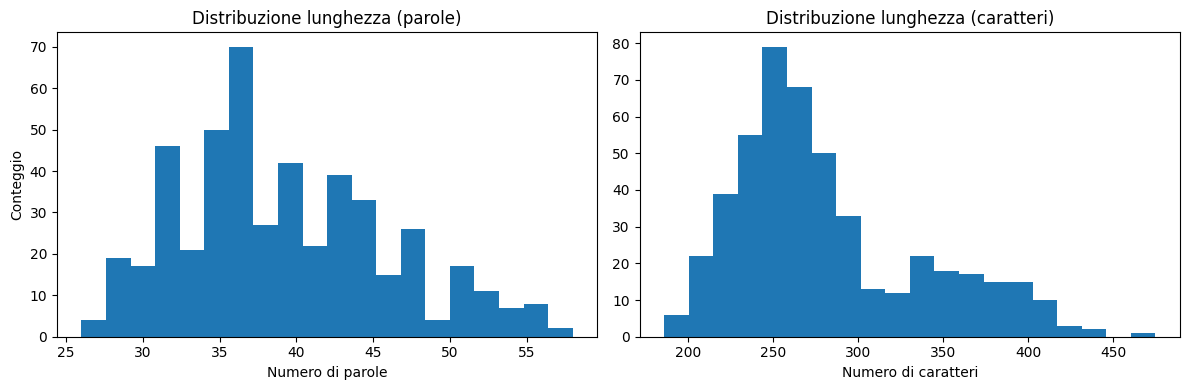

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 

axes[0].hist(df["word_len"], bins=20)
axes[0].set_title("Distribuzione lunghezza (parole)")
axes[0].set_xlabel("Numero di parole")
axes[0].set_ylabel("Conteggio")

axes[1].hist(df["char_len"], bins=20)
axes[1].set_title("Distribuzione lunghezza (caratteri)")
axes[1].set_xlabel("Numero di caratteri")

plt.tight_layout()
plt.show()


### Sezione 5 – Lunghezze medie per categoria e priorità

In questa sezione viene analizzata la relazione tra la lunghezza dei testi e le etichette di categoria e priorità. L’obiettivo è verificare se esistono differenze sistematiche nella dimensione dei ticket associate a specifiche classi.

Questa analisi è rilevante per il triage automatico poiché la lunghezza del testo può costituire un segnale indiretto per il modello di classificazione. Qualora alcune categorie o priorità fossero associate a testi mediamente più lunghi o più brevi, il modello potrebbe sfruttare tale informazione in modo implicito, introducendo un potenziale bias.
L’analisi consente quindi di valutare la coerenza delle strutture testuali generate e di contestualizzare correttamente l’impatto che tali caratteristiche possono avere sull’addestramento e sulla valutazione dei modelli nelle sezioni successive.


In [5]:
print("\n=== Lunghezza media per categoria ===")
print(df.groupby("category")[["word_len", "char_len"]].mean().round(2))

print("\n=== Lunghezza media per priorità ===")
print(df.groupby("priority")[["word_len", "char_len"]].mean().round(2))



=== Lunghezza media per categoria ===
                 word_len  char_len
category                           
Amministrazione     41.99    301.97
Commerciale         37.06    269.21
Tecnico             38.34    275.83

=== Lunghezza media per priorità ===
          word_len  char_len
priority                    
alta         45.71    341.23
bassa        36.48    263.15
media        36.96    259.46


### Sezione 6 – Word Cloud globale dei ticket

In questa sezione viene generata una word cloud a partire dall’intero corpus testuale dei ticket. L’obiettivo dell’analisi è di tipo diagnostico e non esplorativo, la visualizzazione serve a individuare rapidamente le parole più frequenti nel dataset e a comprendere quali segnali lessicali saranno maggiormente enfatizzati dal modello TF-IDF nella fase di classificazione.

È importante sottolineare che la dimensione delle parole nella word cloud riflette esclusivamente la loro frequenza assoluta nel testo e non una rilevanza semantica. Lo strumento viene quindi utilizzato come controllo preliminare per valutare la composizione del vocabolario, l’eventuale presenza di termini eccessivamente ricorrenti e la coerenza del lessico rispetto al dominio applicativo dei ticket. Dall'analisi vengono escluse le stop word italiane.

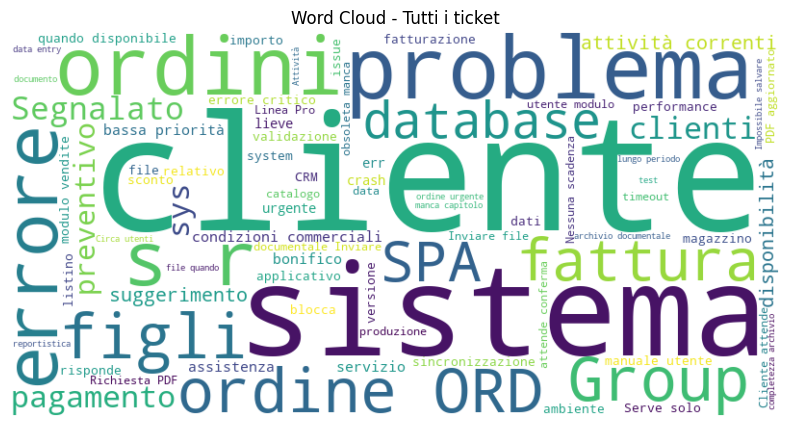

In [6]:
# Unisce tutto il testo
all_text = " ".join(df["text"].astype(str).tolist())

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    stopwords=set(stop_it), # parole comuni da escludere
    max_words=80
).generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Tutti i ticket")
plt.show()


### Sezione 7 – Word Cloud per categoria

In questa sezione viene generata una word cloud separata per ciascuna categoria di ticket (Amministrazione, Tecnico, Commerciale), con l’obiettivo di analizzare la composizione del vocabolario associato a ogni classe.

Il confronto tra le word cloud consente di verificare se le categorie presentano insiemi lessicali distinti oppure se condividono un linguaggio ampiamente sovrapposto. Questa analisi è rilevante per il triage automatico, poiché la presenza di keyword specifiche per categoria rappresenta un segnale informativo potenzialmente sfruttabile da modelli di classificazione basati su TF-IDF.

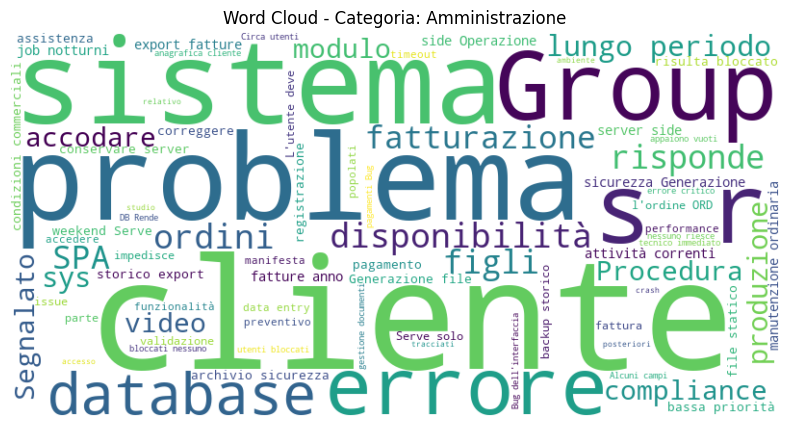

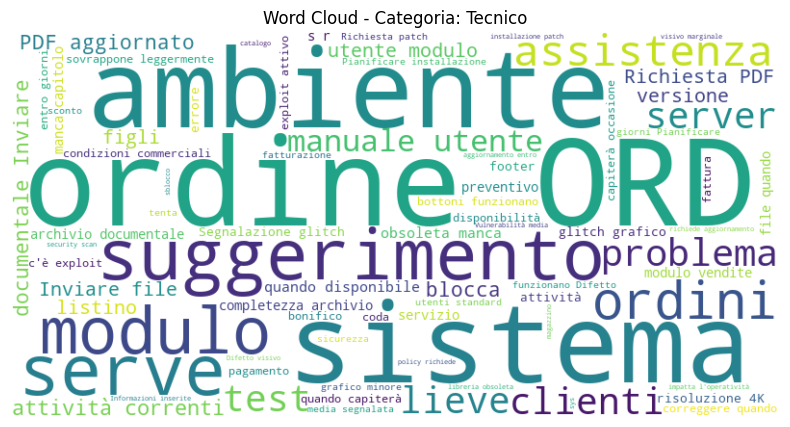

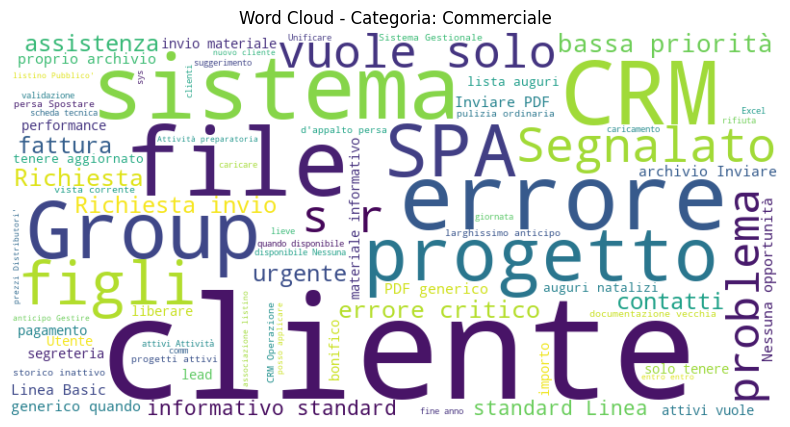

In [7]:
categories = df["category"].unique()

for cat in categories:
    text_cat = " ".join(df.loc[df["category"] == cat, "text"].astype(str))
    if not text_cat.strip():
        continue

    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        stopwords=set(stop_it),
        max_words=80
    ).generate(text_cat)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud - Categoria: {cat}")
    plt.show()


### Sezione 8 – Top keyword globali (TF-IDF)

In questa sezione viene applicata la rappresentazione TF-IDF all’intero corpus testuale dei ticket, con l’obiettivo di individuare i termini maggiormente informativi dal punto di vista discriminativo. A differenza delle analisi basate sulla sola frequenza, TF-IDF consente di valorizzare le parole che risultano rilevanti all’interno di sottoinsiemi di documenti, riducendo il peso dei termini comuni a tutto il corpus.

L’analisi dei punteggi TF-IDF medi permette di esaminare la struttura lessicale del dataset e di comprendere quali segnali testuali saranno maggiormente enfatizzati dai modelli di classificazione basati su rappresentazioni vettoriali sparse. In questo modo è possibile valutare, in modo preliminare, il potenziale informativo del vocabolario generato.

In [8]:
vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words=stop_it,  
    ngram_range=(1, 2)     # unigrams + bigrams
)

X_tfidf = vectorizer.fit_transform(df["text"])
feature_names = np.array(vectorizer.get_feature_names_out())

# Media TF-IDF globale
tfidf_mean = np.asarray(X_tfidf.mean(axis=0)).ravel()
top_n = 20
top_idx = tfidf_mean.argsort()[::-1][:top_n]

top_keywords = pd.DataFrame({
    "term": feature_names[top_idx],
    "tfidf_mean": tfidf_mean[top_idx]
})

top_keywords


,term,tfidf_mean
0,cliente,0.043373
1,ordini,0.027299
2,attività,0.026342
3,dati,0.025925
4,sistema,0.025684
5,solo,0.025355
6,ordine,0.025333
7,errore,0.024164
8,richiesta,0.023436
9,modulo,0.020866


### Sezione 9 – Top keyword TF-IDF per categoria

In questa sezione vengono estratti i termini con valore medio di TF-IDF più elevato per ciascuna categoria di ticket (Amministrazione, Tecnico, Commerciale). L’obiettivo è analizzare la composizione del vocabolario associato a ogni classe e verificare la presenza di segnali lessicali distintivi.

Per ciascuna categoria, l’analisi prevede la selezione dei documenti appartenenti alla classe, il calcolo della media dei valori TF-IDF per ogni termine e l’individuazione dei termini più informativi all’interno del sottoinsieme considerato. Questo approccio consente di osservare quali parole caratterizzano maggiormente ciascun dominio dal punto di vista della rappresentazione vettoriale.


In [9]:
def top_keywords_for_subset(mask, top_n=15):
    # Converte la Series booleana in array NumPy
    mask_array = mask.to_numpy()

    X_sub = X_tfidf[mask_array]
    # media solo sui documenti di quella categoria
    mean_sub = np.asarray(X_sub.mean(axis=0)).ravel()
    idx = mean_sub.argsort()[::-1][:top_n]
    return pd.DataFrame({"term": feature_names[idx], "tfidf_mean": mean_sub[idx]})

for cat in categories:
    print(f"\n=== Top keyword per categoria: {cat} ===")
    mask = (df["category"] == cat)
    display(top_keywords_for_subset(mask, top_n=10))



=== Top keyword per categoria: Amministrazione ===


,term,tfidf_mean
0,cliente,0.047698
1,fatture,0.039932
2,utenti,0.031693
3,errore,0.030471
4,serve,0.029596
5,attività,0.028990
6,risulta,0.028735
7,dati,0.028079
8,problema,0.027075
9,solo,0.025919



=== Top keyword per categoria: Tecnico ===


,term,tfidf_mean
0,ordini,0.044517
1,modulo,0.030978
2,solo,0.026419
3,attività,0.026061
4,dati,0.025754
5,quando,0.025427
6,ordine,0.024543
7,clienti,0.023445
8,vendite,0.023382
9,ambiente,0.021511



=== Top keyword per categoria: Commerciale ===


,term,tfidf_mean
0,cliente,0.084155
1,crm,0.042298
2,linea,0.040877
3,senza,0.037232
4,sistema,0.035374
5,ricerca,0.033333
6,errore,0.030543
7,richiesta,0.029595
8,contatti,0.029527
9,file,0.028824


### Sezione 10 – Duplicati esatti nei testi

In questa sezione viene verificata la presenza di ticket duplicati all’interno del dataset, intesi come testi identici ripetuti più volte. L’obiettivo è valutare se il processo di generazione sintetica abbia introdotto istanze ridondanti che potrebbero influenzare il processo di addestramento dei modelli.

L’individuazione di duplicati è un passaggio rilevante nella preparazione dei dati, poiché la ripetizione di testi identici può alterare la distribuzione informativa del dataset e incidere sul comportamento dei modelli di classificazione supervisionata. In particolare, la presenza di duplicati può semplificare artificialmente il compito di apprendimento e influenzare la stima delle prestazioni in fase di valutazione.

In [10]:
# Duplicati su 'text'
dup_mask = df.duplicated(subset=["text"], keep=False)
duplicates = df[dup_mask].sort_values(by="text")

print(f"Numero di ticket duplicati (testo identico): {duplicates.shape[0]}")
duplicates.head(10)


Numero di ticket duplicati (testo identico): 7


,id,title,body,category,priority,title_length,body_length,text,char_len,word_len
283,284,NaN,Anomalia nel calcolo sconti: il modulo vendite...,Tecnico,media,0,254,Anomalia nel calcolo sconti: il modulo vendite...,254,39
313,314,NaN,Anomalia nel calcolo sconti: il modulo vendite...,Tecnico,media,0,254,Anomalia nel calcolo sconti: il modulo vendite...,254,39
27,28,NaN,Controllo qualità dati contabili storici per a...,Amministrazione,media,0,266,Controllo qualità dati contabili storici per a...,266,37
110,111,NaN,Controllo qualità dati contabili storici per a...,Amministrazione,media,0,266,Controllo qualità dati contabili storici per a...,266,37
195,196,NaN,Info su messaggio di cortesia in processo ordi...,Tecnico,media,0,209,Info su messaggio di cortesia in processo ordi...,209,30
258,259,NaN,Info su messaggio di cortesia in processo ordi...,Tecnico,media,0,209,Info su messaggio di cortesia in processo ordi...,209,30
358,359,NaN,Info su messaggio di cortesia in processo ordi...,Tecnico,media,0,209,Info su messaggio di cortesia in processo ordi...,209,30


### Sezione 11 – Quasi-duplicati (similarità coseno)

In questa sezione viene analizzata la presenza di quasi-duplicati, ovvero coppie di ticket che non risultano identiche ma presentano un contenuto testuale estremamente simile. L’obiettivo è valutare il grado di ridondanza del dataset oltre i duplicati esatti.

L’analisi viene condotta rappresentando i testi tramite TF-IDF e calcolando la similarità coseno tra le coppie di ticket. Viene quindi applicata una soglia di similarità elevata per identificare testi molto vicini nello spazio vettoriale, considerabili come quasi equivalenti dal punto di vista informativo.

Questa verifica consente di controllare quanto il processo di generazione abbia prodotto strutture testuali ripetitive, anche in presenza di variazioni superficiali. L’analisi dei quasi-duplicati fornisce quindi un ulteriore elemento di contesto metodologico utile per interpretare il comportamento dei modelli di classificazione nelle fasi successive dell’elaborato.

In [11]:
# Calcolo similarità coseno
subset = df.reset_index(drop=True)
X_sub = vectorizer.fit_transform(subset["text"])

sim_matrix = cosine_similarity(X_sub)

pairs = []
threshold = 0.9 # soglia di similarità al 90%

n = sim_matrix.shape[0]
for i in range(n):
    for j in range(i+1, n):
        if sim_matrix[i, j] >= threshold:
            pairs.append((i, j, sim_matrix[i, j]))

len(pairs), pairs[:10]

pairs_df = pd.DataFrame(
    pairs,
    columns=["idx_1", "idx_2", "cosine_similarity"]
)

# Aggancio il testo reale
pairs_df["text_1"] = pairs_df["idx_1"].apply(lambda i: subset.loc[i, "text"])
pairs_df["text_2"] = pairs_df["idx_2"].apply(lambda i: subset.loc[i, "text"])

# Ordino per similarità decrescente
print(f"Numero di ticket simili: {pairs_df.shape[0]}")
pairs_df = pairs_df.sort_values("cosine_similarity", ascending=False)
pairs_df.head(50)


Numero di ticket simili: 530


,idx_1,idx_2,cosine_similarity,text_1,text_2
115,68,135,1.000000,Monitoraggio passivo dei log modulo gestione u...,Monitoraggio passivo dei log modulo gestione u...
394,283,313,1.000000,Anomalia nel calcolo sconti: il modulo vendite...,Anomalia nel calcolo sconti: il modulo vendite...
205,162,293,1.000000,Query di ricerca clienti lenta: manca indice s...,Query di ricerca clienti lenta: manca indice s...
204,162,225,1.000000,Query di ricerca clienti lenta: manca indice s...,Query di ricerca clienti lenta: manca indice s...
179,157,303,1.000000,Feedback su usabilità interfaccia reportistica...,Feedback su usabilità interfaccia reportistica...
362,260,283,1.000000,Anomalia nel calcolo sconti: il modulo vendite...,Anomalia nel calcolo sconti: il modulo vendite...
364,260,313,1.000000,Anomalia nel calcolo sconti: il modulo vendite...,Anomalia nel calcolo sconti: il modulo vendite...
319,225,293,1.000000,Query di ricerca clienti lenta: manca indice s...,Query di ricerca clienti lenta: manca indice s...
228,170,192,1.000000,Curiosità su dati storici cliente: ho notato r...,Curiosità su dati storici cliente: ho notato r...
281,195,258,1.000000,Info su messaggio di cortesia in processo ordi...,Info su messaggio di cortesia in processo ordi...


### Sezione 12 – Correlazione tra categoria e priorità

In questa sezione viene analizzata la relazione tra categoria e priorità mediante una tabella di contingenza e il calcolo delle percentuali per riga. L’obiettivo è verificare se la distribuzione delle priorità risulti omogenea tra le diverse categorie oppure se emergano differenze sistematiche.

Questa analisi è rilevante per il triage automatico poiché un’eventuale associazione tra categoria e priorità potrebbe introdurre dipendenze indirette tra le etichette. In tal caso, un modello di classificazione della priorità potrebbe sfruttare implicitamente l’informazione di categoria, anziché basarsi esclusivamente sul contenuto testuale del ticket.


In [12]:
# Tabella di contingenza
contingency = pd.crosstab(df["category"], df["priority"])
print("=== Tabella categoria x priorità ===")
print(contingency)

# Percentuali per riga
print("\n=== Percentuali per categoria (riga) ===")
print((contingency.div(contingency.sum(axis=1), axis=0) * 100).round(2))

=== Tabella categoria x priorità ===
priority         alta  bassa  media
category                           
Amministrazione    41     42     61
Commerciale        35     37     48
Tecnico            50     63    103

=== Percentuali per categoria (riga) ===
priority          alta  bassa  media
category                            
Amministrazione  28.47  29.17  42.36
Commerciale      29.17  30.83  40.00
Tecnico          23.15  29.17  47.69


### Sezione 13 – Test Chi-Quadrato sull’associazione categoria–priorità
In questa sezione viene applicato un test di indipendenza chi-quadrato alla tabella di contingenza tra categoria e priorità. L’obiettivo è verificare, in modo formale, se le due variabili possano essere considerate indipendenti oppure se esista una relazione statistica tra il tipo di ticket e il livello di priorità assegnato.

Il test chi-quadrato consente di confrontare le frequenze osservate con quelle attese sotto l’ipotesi di indipendenza, fornendo una misura quantitativa del grado di associazione tra le variabili categoriali considerate. Questo passaggio affianca l’analisi esplorativa basata sulle percentuali e introduce una verifica statistica esplicita della relazione tra categoria e priorità.

L’esecuzione del test fornisce quindi un riferimento metodologico utile per valutare se eventuali pattern osservati nelle distribuzioni siano riconducibili a una struttura statistica del dataset oppure possano essere attribuiti a fluttuazioni dovute alla generazione sintetica dei dati.


In [13]:
chi2, p, dof, expected = chi2_contingency(contingency.values)
print(f"\nChi2: {chi2:.3f}, dof: {dof}, p-value: {p:.5f}")



Chi2: 2.719, dof: 4, p-value: 0.60582


### Sezione 14 – Grafico bar clusterizzato: distribuzione delle priorità per categoria

In questa sezione viene rappresentata graficamente la distribuzione delle priorità all’interno di ciascuna categoria mediante un grafico a barre clusterizzate. La visualizzazione consente di confrontare, per ogni dominio (Amministrazione, Commerciale, Tecnico), il numero di ticket associati alle diverse classi di priorità.

L’obiettivo della rappresentazione grafica è fornire una sintesi visiva della relazione tra categoria e priorità, complementare alla tabella di contingenza e alle analisi statistiche formali. Il grafico permette infatti di esplorare in modo immediato la struttura delle frequenze congiunte e di valutare eventuali differenze nella distribuzione delle priorità tra le categorie.

Questa visualizzazione ha quindi una funzione esplorativa e di supporto metodologico, consente di verificare visivamente la coerenza delle distribuzioni e di fornire un ulteriore elemento descrittivo utile alla contestualizzazione delle successive fasi di modellazione, senza introdurre interpretazioni o conclusioni sui risultati.


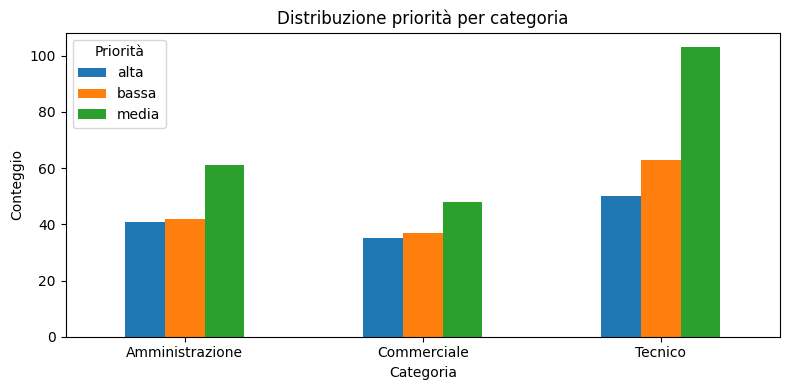

In [14]:
contingency.plot(kind="bar", figsize=(8, 4))
plt.title("Distribuzione priorità per categoria")
plt.xlabel("Categoria")
plt.ylabel("Conteggio")
plt.xticks(rotation=0)
plt.legend(title="Priorità")
plt.tight_layout()
plt.show()
